# Mineral area analysis

## Get the area of each mineral unit as a function of distance from Argyre center 

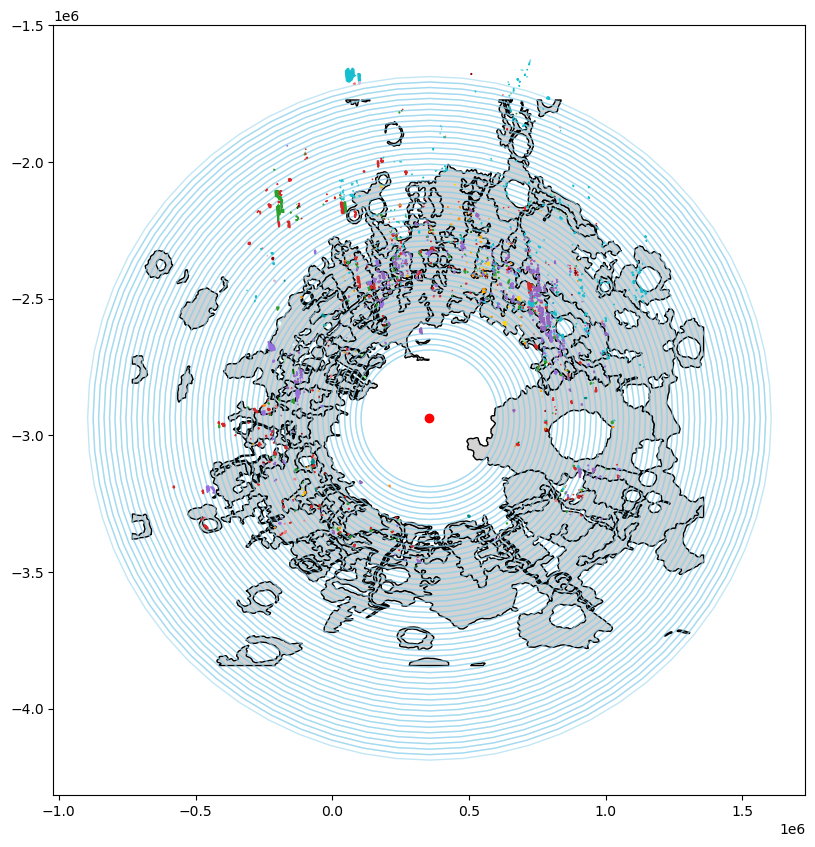

In [2]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

category_colors = {
    'type 1 olivine': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'type 2 olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'hcp + olivine': {'High': 'tab:purple', 'Moderate': 'mediumpurple', 'Low': 'thistle'},
    'lcp': {'High': 'tab:cyan', 'Moderate': 'darkcyan', 'Low': 'lightcyan'},
    'plagioclase': {'High': 'gold', 'Moderate': 'orange', 'Low': 'darkorange'},
}

os.environ["PROJ_IGNORE_CELESTIAL_BODY"] = "YES"

# Function to filter data based on confidence levels and categories
def filter_data(df, confidence_levels, categories_to_include):
    if not confidence_levels:
        return df[(df['Category'] != 'No valid mineral') & (df['Category'].isin(categories_to_include))]
    else:
        confidence_levels_lower = [a.lower() for a in confidence_levels]
        return df[(df['Category'] != 'No valid mineral') & 
                  (df['Confidence'].isin(confidence_levels_lower)) & 
                  (df['Category'].isin(categories_to_include))]

# File paths
geological_units_path = "/Users/phillipsm/Documents/Research/MassifMapping/ArgyreMap/Argyre_3M_preliminary/Argyre_working/Argyre_3M_v10.gdb"
mineral_units_path = '/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/Argyre/categorized_olivine_2'
layer_name = "UnitPolygons24"
center_point_path = '/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/arygre_center_point.shp'

# Load the geological units and center point(s)
geological_units = gpd.read_file(geological_units_path, layer=layer_name)
center_points = gpd.read_file(center_point_path)

# load all the gpkg files in mineral_units_path, then concat them into a single gdf
mineral_units = gpd.GeoDataFrame()
for file in os.listdir(mineral_units_path):
    if file.endswith('.gpkg'):
        gdf = gpd.read_file(os.path.join(mineral_units_path, file))
        gdf = gdf.to_crs(center_points.crs)  # Ensure CRS is the same as center_points
        mineral_units = pd.concat([mineral_units, gdf], ignore_index=True)

# Filter data based on confidence levels and categories to include
confidence_levels_to_include = ['High', 'Moderate', 'Low']
# confidence_levels_to_include = ['High', 'Moderate']
# confidence_levels_to_include = ['High']
categories_to_include = ['Type 1 olivine', 'Type 2 olivine', 'plagioclase', 'lcp', 'hcp + olivine']
catconf_to_include = []
for cat in categories_to_include:
    for conf in confidence_levels_to_include:
        catconf_to_include.append(f'{cat} ({conf})')

mineral_units = mineral_units[mineral_units['Category'].isin(catconf_to_include)]

# fix invalid geometries
invalid_geometries = mineral_units[~mineral_units.is_valid]
if invalid_geometries.shape[0] > 0:
    mineral_units['geometry'] = mineral_units['geometry'].buffer(0)

# Ensure both are in the same CRS (projected CRS is preferred for area calculations)
geological_units = geological_units.to_crs(center_points.crs)

# Define the geological units of interest
target_units = [
    'Argyre basin member 2', 'Argyre basin member 3', 'Argyre rim materials',
    'Argyre rim and basin materials', 'Argye rim and basin materials',
    'Argyre basin and rim materials', 'Young crater materials', 'Old crater materials'
]

# Filter geological units to include only the specified units
filtered_geological_units = geological_units[geological_units['UnitName'].isin(target_units)]

# Define buffer distances for rings in meters
min_d, max_d = (250000, 1250000)
bs = 20000  # bin spacing in meters
buffer_distances = [min_d + i * bs for i in range(1+int((max_d - min_d) / bs))]

# Initialize an empty list to store results
summary_list = []
# Initialize an empty GeoDataFrame for the ring buffers
ring_buffers = gpd.GeoDataFrame(columns=['geometry', 'ring_id', 'distance'], crs=center_points.crs)
intersecting_units_list = []

# Calculate area of geological units within each ring buffer
for i, dist in enumerate(buffer_distances):
    outer_buffer = center_points.geometry.buffer(dist)
    
    # Check for an inner buffer (to create a true ring)
    if i == 0:
        ring = outer_buffer
    else:
        inner_buffer = center_points.geometry.buffer(buffer_distances[i - 1])
        ring = outer_buffer.difference(inner_buffer.unary_union)  # Create ring by subtracting inner buffer
    
    # Convert the ring to a GeoDataFrame
    ring_gdf = gpd.GeoDataFrame(geometry=ring, crs=center_points.crs)
    ring_gdf['distance'] = dist  # Add distance label for reference
       
    # Append to the main GeoDataFrame
    ring_buffers = pd.concat([ring_buffers, ring_gdf], ignore_index=True)
    
    # Intersect geological units with the ring to get the area of each unit within this ring
    intersecting_units = filtered_geological_units[filtered_geological_units.intersects(ring_gdf.unary_union)]
    intersecting_units = intersecting_units.copy()
    intersecting_units['geometry'] = intersecting_units['geometry'].intersection(ring_gdf.unary_union)  # Crop to the ring
    intersecting_units['area_within_ring'] = intersecting_units.intersection(ring_gdf.unary_union).area
    intersecting_units['distance'] = dist

    intersecting_units_list.append(intersecting_units)
    
    # Summarize the area by geological unit within the ring
    area_summary = (
        intersecting_units.groupby('UnitName')['area_within_ring']
        .sum()
        .reindex(target_units, fill_value=0)
        .reset_index()
    )
    
    # Add distance and ring ID to the summary
    area_summary['ring_id'] = i + 1
    area_summary['distance'] = dist
    
    # Append to the summary list
    summary_list.append(area_summary)

# Initialize an empty list to store results
mineral_area_within_ring = []

# Iterate over each unique category in the mineral_units GeoDataFrame
for category in mineral_units['Category'].unique():
    # Filter the mineral_units to get the current category's geometries
    category_units = mineral_units[mineral_units['Category'] == category]

    # Iterate over each intersecting geological unit
    for intersecting_units in intersecting_units_list:
        for _, geo_unit in intersecting_units.iterrows():
            # Intersect the geological unit with the current mineral category geometries
            intersected = category_units[category_units.intersects(geo_unit.geometry)]
            # Calculate the intersection area if there's any overlap
            if intersected.empty:
                # Append results for this geological unit and mineral category
                mineral_area_within_ring.append({
                    'geo_unit_id': np.nan,  
                    'mineral_category': category,
                    'area_within_ring': 0,
                    'distance': geo_unit['distance'],
                })
            else:
                intersection = intersected.geometry.intersection(geo_unit.geometry)
                area_within_ring = intersection.area.sum()  # Sum the area of the intersections if there are multiple parts

                # Append results for this geological unit and mineral category
                mineral_area_within_ring.append({
                    'geo_unit_id': geo_unit['UnitName'],  
                    'mineral_category': category,
                    'area_within_ring': area_within_ring,
                    'distance': geo_unit['distance'],
                })

# Convert the results into a new GeoDataFrame
mineral_area_gdf = gpd.GeoDataFrame(mineral_area_within_ring)
# Concatenate all summaries into a single DataFrame
summary_df = pd.concat(summary_list, ignore_index=True)

# Calculate total area per ring for normalization
area_sum_by_ring = summary_df.groupby(['ring_id', 'distance'])['area_within_ring'].sum().reset_index()
total_area = area_sum_by_ring['area_within_ring'].sum()
area_sum_by_ring['normalized_area'] = area_sum_by_ring['area_within_ring'] / total_area

# Optional: Visualize the rings and geological units
fig, ax = plt.subplots(figsize=(10, 10))
filtered_geological_units.plot(ax=ax,color='lightgrey', edgecolor='black')
# ring_gdf.plot(ax=ax, color='none', edgecolor='red')
# Plot the rings (buffered zones) around the central points
ring_buffers.plot(ax=ax, color='none', edgecolor='skyblue', label='Rings', alpha=0.5)
for i, c in enumerate(catconf_to_include):
    cat, conf = c.split('(')
    cat = cat.strip()
    conf = conf.replace(')', '').strip()
    mineral_units[mineral_units['Category'] == c].plot(ax=ax, color=category_colors[cat.lower()][conf], edgecolor=category_colors[cat.lower()][conf], label=c)
# mineral_units.plot(ax=ax, color='none', edgecolor='red', label='Mineral Units')
center_points.plot(ax=ax, color='red')
plt.show()


## combine values

In [3]:
geo_units_areas_by_ring = [g.area.sum() for g in intersecting_units_list]

# Convert the list into a DataFrame
df = pd.DataFrame(mineral_area_within_ring)

# Pivot the DataFrame
pivot_df = df.pivot_table(index='distance', columns='mineral_category', values='area_within_ring', aggfunc='sum')

# Reset index to get 'distance' as a column (optional)
pivot_df.reset_index(inplace=True)

# Step 1: Extract mineral names (before parentheses)
pivot_df.columns = pivot_df.columns.str.extract(r'([a-zA-Z0-9\s\+]+)')[0]

# Step 2: Group by mineral name and sum the values for each mineral
pivot_df_combined = pivot_df.groupby(pivot_df.columns, axis=1).sum()

# Step 3: Move the 'distance' column to the first position
pivot_df_combined = pivot_df_combined[['distance'] + [col for col in pivot_df_combined.columns if col != 'distance']]

# pivot_df_combined['ring_geounit_area'] = geo_units_areas_by_ring

# Display the result
pivot_df_combined


,distance,Type 1 olivine,Type 2 olivine,hcp + olivine,lcp,plagioclase
0,250000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,270000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,290000.0,1.719661e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,310000.0,4.274402e+05,0.000000e+00,1.198087e+07,0.000000e+00,0.000000e+00
4,330000.0,2.587034e+06,0.000000e+00,2.565296e+07,0.000000e+00,1.268719e+06
5,350000.0,1.265398e+07,4.566189e+07,0.000000e+00,0.000000e+00,2.695796e+05
6,370000.0,6.042518e+06,0.000000e+00,6.797411e+06,0.000000e+00,5.142486e+05
7,390000.0,1.639000e+07,3.963201e+07,2.705428e+07,0.000000e+00,0.000000e+00
8,410000.0,4.453734e+05,1.809939e+07,1.621815e+07,0.000000e+00,2.145020e+06
9,430000.0,7.875672e+06,6.867716e+07,3.938592e+06,2.148032e+06,1.115363e+07


## Plot the relative area within each ring

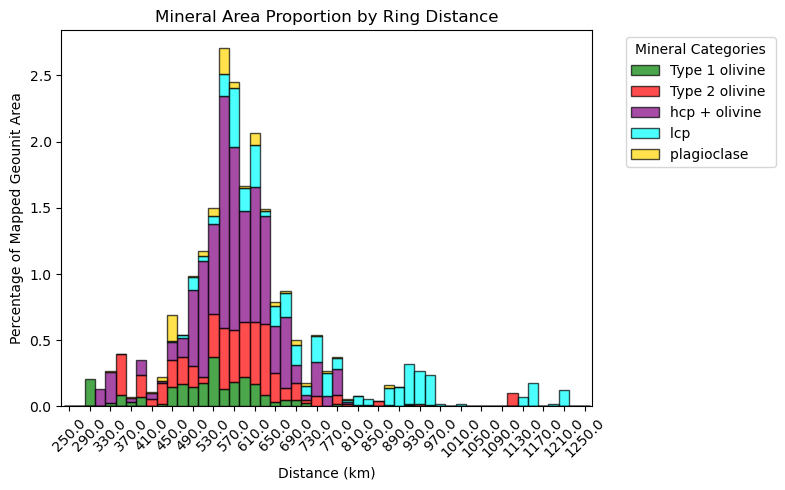

,Type 1 olivine,Type 2 olivine,hcp + olivine,lcp,plagioclase
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.205151,0.000000,0.000000,0.000000,0.000000
3,0.004497,0.000000,0.126034,0.000000,0.000000
4,0.023561,0.000000,0.233633,0.000000,0.011555
5,0.085582,0.308824,0.000000,0.000000,0.001823
6,0.031351,0.000000,0.035268,0.000000,0.002668
7,0.069561,0.168203,0.114821,0.000000,0.000000
8,0.001273,0.051719,0.046343,0.000000,0.006129
9,0.018431,0.160725,0.009217,0.005027,0.026103


In [4]:
mineral_colors = [
    'green',  # Type 1 olivine
    'red',   # Type 2 olivine
    'purple',    # hcp + olivine
    'cyan',      # lcp
    'gold'    # plagioclase
]

# ----------------------------------------------------------------
# pick 1 of these:
# ----------------------------------------------------------------

# case 1:
# Normalize the values to 100%
# pivot_df_combined_normalized = pivot_df_combined.drop('distance', axis=1).div(pivot_df_combined.drop('distance', axis=1).sum(axis=1), axis=0) * 100
# yl = "Relative Percentage of Mapped Geounit Area\nCovered by Each Mineral"
# ----------------------------------------------------------------

# # case 2:
# # normalize to ring with max area
# # Calculate the maximum area across all rows (row with highest total area)
# max_area = pivot_df_combined.drop('distance', axis=1).sum(axis=1).max()

# # Normalize each row by the maximum area value
# pivot_df_combined_normalized = pivot_df_combined.drop('distance', axis=1).div(max_area) * 100
# ----------------------------------------------------------------

# # case 3:
# normalize each column by the geounit area within that ring.
geo_units_areas_by_ring_series = pd.Series(geo_units_areas_by_ring)

# Divide each row by the corresponding value in geo_units_areas_by_ring and multiply by 100 for percentage
pivot_df_combined_normalized = pivot_df_combined.drop('distance', axis=1).div(geo_units_areas_by_ring_series, axis=0) * 100
yl = "Percentage of Mapped Geounit Area"
# ----------------------------------------------------------------

# Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))
pivot_df_combined_normalized.plot(ax=ax, kind='bar', stacked=True, color=mineral_colors, width=1.0, edgecolor='black', alpha=0.7)

# Add labels and title
plt.title("Mineral Area Proportion by Ring Distance")
plt.xlabel("Distance (km)")
plt.ylabel(yl)
# plt.ylim([0, 100])
plt.xticks(range(0, len(pivot_df_combined), 2), round(pivot_df_combined['distance'][::2]/1000, 0), rotation=45)  # Adjust ticks and rotate them
plt.legend(title="Mineral Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

pivot_df_combined_normalized

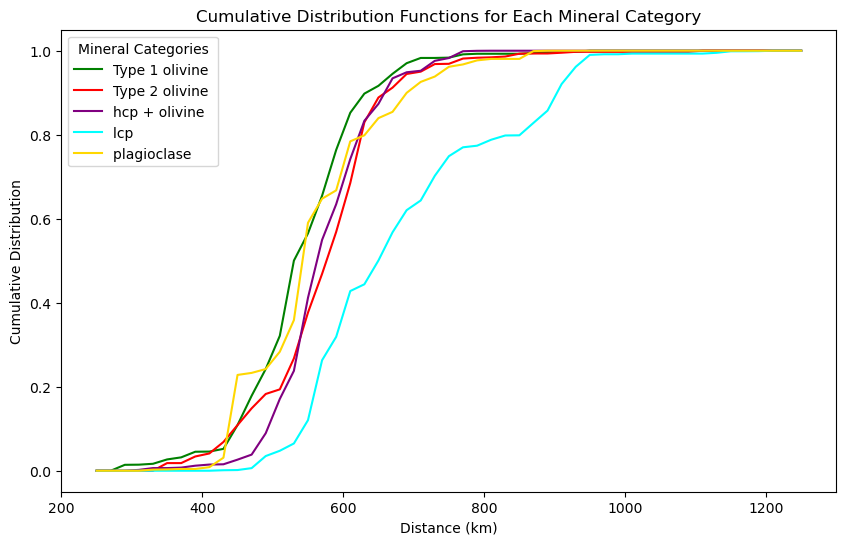

In [5]:
# Calculate the cumulative distribution functions (CDF) for each mineral category
cdf_df = pivot_df_combined.drop('distance', axis=1).cumsum()

# Normalize the CDFs to range from 0 to 1
cdf_df = cdf_df.div(cdf_df.iloc[-1])

# calculate the derivative of the cdf_df
# cdf_df = cdf_df.diff().fillna(cdf_df.iloc[0])

# Plot the CDFs
fig, ax = plt.subplots(figsize=(10, 6))

for i, column in enumerate(cdf_df.columns):
    ax.plot(pivot_df_combined['distance'] / 1000, cdf_df[column], label=column, color=mineral_colors[i])

# Add labels and title
ax.set_title('Cumulative Distribution Functions for Each Mineral Category')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Cumulative Distribution')
ax.legend(title='Mineral Categories')

# Show the plot
plt.show()

## calculate summary statistics

In [ ]:
# pivot_df_combined #.iloc[:33].mean()
# pivot_df_combined.sum()
# geo_units_areas_by_ring

[7652198213.77271,
 5889317648.766661,
 8382408523.566637,
 9506025701.83767,
 10980042998.18081,
 14785719932.219114,
 19273475111.651405,
 23562055568.647926,
 34995679469.229385,
 42729535662.80113,
 48419799826.63565,
 49502129885.54616,
 53408614520.110085,
 55805458316.83576,
 58224525742.80162,
 59590487240.10819,
 59445247859.555695,
 60356712218.44188,
 63062355623.983,
 67198130614.093666,
 68198691889.76106,
 67792660476.092575,
 63868870837.25309,
 59554676079.06784,
 55885302553.25457,
 51835426292.8072,
 48235882949.424866,
 42921546630.13512,
 40225082770.32475,
 41108608413.56733,
 41854756385.43816,
 41864965428.90564,
 37265775306.34694,
 38928329122.1042,
 30095184942.270603,
 23872952311.620296,
 17960528660.864246,
 16646833427.064016,
 15147497327.763474,
 12190333898.756954,
 8391883962.832873,
 5269564876.624977,
 5426499182.841436,
 6756983042.187474,
 5245813824.089394,
 3817575684.5033355,
 4350776246.670423,
 2402897056.8779693,
 1521040489.7332156,
 1312502

In [5]:
proportions = 100 * (pivot_df_combined.iloc[:,1:].sum() / pivot_df_combined.iloc[:,1:].sum().sum())
proportions

0
Type 1 olivine     10.469530
Type 2 olivine     20.520161
hcp + olivine      49.580798
lcp                15.330468
plagioclase         4.099044
dtype: float64

In [5]:
# Add a column for the area of each ROI
mineral_units['area'] = mineral_units.geometry.area

# Calculate each statistic separately
median_area = mineral_units.groupby('Category')['area'].median().rename('median_area').reset_index()
min_area = mineral_units.groupby('Category')['area'].min().rename('min_area').reset_index()
max_area = mineral_units.groupby('Category')['area'].max().rename('max_area').reset_index()
quantile_area = mineral_units.groupby('Category')['area'].quantile(0.25).rename('quantile_25_area').reset_index()

# Merge all the statistics into a single DataFrame
stats_area_by_category = median_area.merge(min_area, on='Category') \
                        .merge(max_area, on='Category') \
                        .merge(quantile_area, on='Category')
stats_area_by_category #.to_excel('stats_area_by_category.xlsx', index=False)


,Category,median_area,min_area,max_area,quantile_25_area
0,Type 1 olivine (High),3.151128e+06,2.703747e+05,4.485619e+08,1.455972e+06
1,Type 1 olivine (Low),2.362582e+06,3.919704e+05,1.719661e+07,1.160817e+06
2,Type 1 olivine (Moderate),1.040510e+06,3.870982e+05,3.033298e+07,7.044123e+05
3,Type 2 olivine (High),3.995020e+06,8.142861e+04,3.299886e+08,1.237660e+06
4,Type 2 olivine (Low),4.652649e+06,2.348486e+05,3.551699e+07,1.132897e+06
5,Type 2 olivine (Moderate),2.149256e+06,1.346593e+05,6.548730e+07,8.593061e+05
6,hcp + olivine (High),4.957692e+06,2.864354e+05,3.373395e+08,1.997223e+06
7,hcp + olivine (Low),6.685174e+06,1.055288e+06,2.834905e+07,3.320765e+06
8,hcp + olivine (Moderate),5.066121e+06,2.412087e+05,4.592121e+08,1.678242e+06
9,lcp (High),2.665794e+06,2.412087e+05,6.984123e+08,1.418163e+06


# Azimuthal analysis

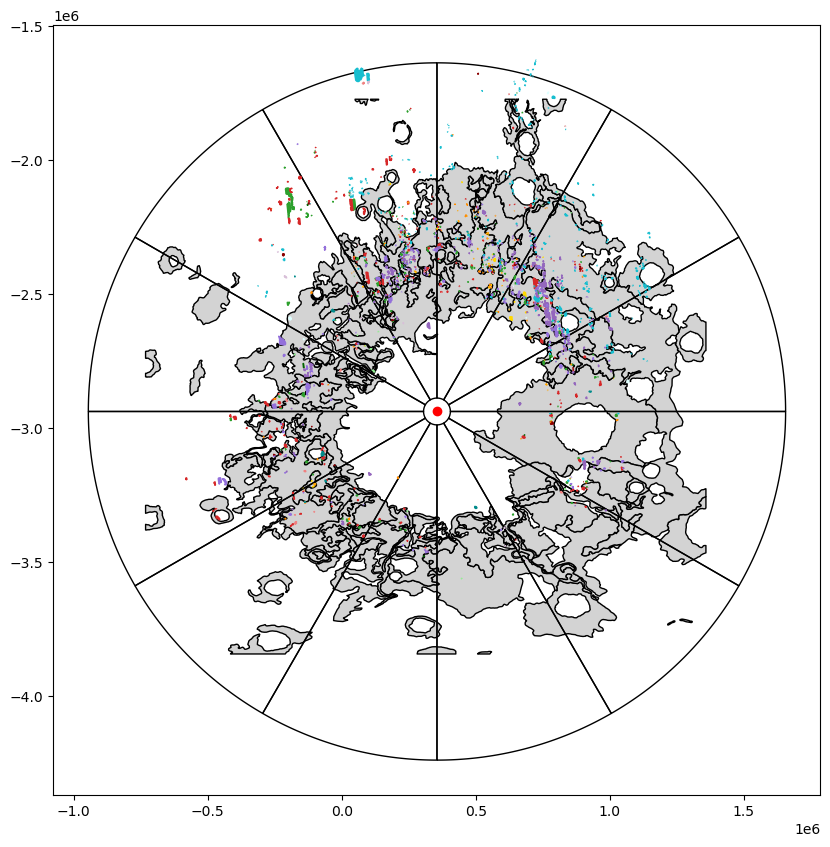

In [59]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

category_colors = {
    'type 1 olivine': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'type 2 olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'hcp + olivine': {'High': 'tab:purple', 'Moderate': 'mediumpurple', 'Low': 'thistle'},
    'lcp': {'High': 'tab:cyan', 'Moderate': 'darkcyan', 'Low': 'lightcyan'},
    'plagioclase': {'High': 'gold', 'Moderate': 'orange', 'Low': 'darkorange'},
}

os.environ["PROJ_IGNORE_CELESTIAL_BODY"] = "YES"

# Function to filter data based on confidence levels and categories
def filter_data(df, confidence_levels, categories_to_include):
    if not confidence_levels:
        return df[(df['Category'] != 'No valid mineral') & (df['Category'].isin(categories_to_include))]
    else:
        confidence_levels_lower = [a.lower() for a in confidence_levels]
        return df[(df['Category'] != 'No valid mineral') & 
                  (df['Confidence'].isin(confidence_levels_lower)) & 
                  (df['Category'].isin(categories_to_include))]

# File paths
geological_units_path = "/Users/phillipsm/Documents/Research/MassifMapping/ArgyreMap/Argyre_3M_preliminary/Argyre_working/Argyre_3M_v10.gdb"
mineral_units_path = '/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/Argyre/categorized_olivine_2'
layer_name = "UnitPolygons24"
center_point_path = '/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/arygre_center_point.shp'

# Load the geological units and center point(s)
geological_units = gpd.read_file(geological_units_path, layer=layer_name)
center_points = gpd.read_file(center_point_path)

# load all the gpkg files in mineral_units_path, then concat them into a single gdf
mineral_units = gpd.GeoDataFrame()
for file in os.listdir(mineral_units_path):
    if file.endswith('.gpkg'):
        gdf = gpd.read_file(os.path.join(mineral_units_path, file))
        gdf = gdf.to_crs(center_points.crs)  # Ensure CRS is the same as center_points
        mineral_units = pd.concat([mineral_units, gdf], ignore_index=True)

# Filter data based on confidence levels and categories to include
confidence_levels_to_include = ['High', 'Moderate', 'Low']
# confidence_levels_to_include = ['High', 'Moderate']
# confidence_levels_to_include = ['High']
categories_to_include = ['Type 1 olivine', 'Type 2 olivine', 'plagioclase', 'lcp', 'hcp + olivine']
catconf_to_include = []
for cat in categories_to_include:
    for conf in confidence_levels_to_include:
        catconf_to_include.append(f'{cat} ({conf})')

mineral_units = mineral_units[mineral_units['Category'].isin(catconf_to_include)]

# fix invalid geometries
invalid_geometries = mineral_units[~mineral_units.is_valid]
if invalid_geometries.shape[0] > 0:
    mineral_units['geometry'] = mineral_units['geometry'].buffer(0)

# Ensure both are in the same CRS (projected CRS is preferred for area calculations)
geological_units = geological_units.to_crs(center_points.crs)

# Define the geological units of interest
target_units = [
    'Argyre basin member 2', 'Argyre basin member 3', 'Argyre rim materials',
    'Argyre rim and basin materials', 'Argye rim and basin materials',
    'Argyre basin and rim materials', 'Young crater materials', 'Old crater materials'
]

# Filter geological units to include only the specified units
filtered_geological_units = geological_units[geological_units['UnitName'].isin(target_units)]

# Define buffer distances for rings in meters
min_d, max_d = (50000, 1300000)
# bs = 20000  # bin spacing in meters
# buffer_distances = [min_d + i * bs for i in range(1+int((max_d - min_d) / bs))]

# Initialize an empty list to store results
summary_list = []

# ---------------------------------------------------------------
# ---------------------------------------------------------------
# ---------------------------------------------------------------
# Initialize an empty GeoDataFrame for the ring buffers
wedge_buffers = gpd.GeoDataFrame(columns=['geometry', 'wedge_id', 'angle_range'], crs=center_points.crs)
# geo_intersecting_units_list = []
intersecting_units_list = []

# Define the number of wedges and angles for azimuthal division
num_wedges = 12  # Divide the circle into 8 wedges (e.g., 45-degree sectors)
angles = np.linspace(0, 360, num_wedges + 1)  # Define angular ranges

# Function to create a wedge geometry
def create_wedge(center, min_radius, max_radius, angle_min, angle_max, num_points=100):
    angles = np.linspace(np.radians(angle_min), np.radians(angle_max), num_points)
    outer_arc = [
        (center.x + max_radius * np.cos(a), center.y + max_radius * np.sin(a)) for a in angles
    ]
    inner_arc = [
        (center.x + min_radius * np.cos(a), center.y + min_radius * np.sin(a)) for a in reversed(angles)
    ]
    return gpd.GeoSeries(Polygon(outer_arc + inner_arc))


# Calculate area of geological units within each ring buffer
for i in range(len(angles) - 1):

    angle_min, angle_max = angles[i], angles[i + 1]
    wedge_id = i + 1
    angle_range = f"{angle_min}-{angle_max}°"
    
    wedge = create_wedge(center_points.geometry, min_d, max_d, angle_min, angle_max)

    # Convert the ring to a GeoDataFrame
    wedge_gdf = gpd.GeoDataFrame(geometry=wedge, crs=center_points.crs)
    wedge_gdf['angle_range'] = angle_range  # Add distance label for reference
       
    # Append to the main GeoDataFrame
    wedge_buffers = pd.concat([wedge_buffers, wedge_gdf], ignore_index=True)
    
    # Intersect geological units with the ring to get the area of each unit within this ring
    intersecting_units = filtered_geological_units[filtered_geological_units.intersects(wedge_gdf.unary_union)]
    intersecting_units = intersecting_units.copy()
    intersecting_units['geometry'] = intersecting_units['geometry'].intersection(wedge_gdf.unary_union)  # Crop to the ring
    intersecting_units['area_within_wedge'] = intersecting_units.intersection(wedge_gdf.unary_union).area
    intersecting_units['angle_range'] = angle_range

    intersecting_units_list.append(intersecting_units)
    
    # Summarize the area by geological unit within the ring
    area_summary = (
        intersecting_units.groupby('UnitName')['area_within_wedge']
        .sum()
        .reindex(target_units, fill_value=0)
        .reset_index()
    )
    
    # Add distance and ring ID to the summary
    area_summary['wedge_id'] = wedge_id
    area_summary['angle_range'] = angle_range
    
    # Append to the summary list
    summary_list.append(area_summary)

# Initialize an empty list to store results
mineral_area_within_wedge = []

# Iterate over each unique category in the mineral_units GeoDataFrame
for category in mineral_units['Category'].unique():
    # Filter the mineral_units to get the current category's geometries
    category_units = mineral_units[mineral_units['Category'] == category]

    # Iterate over each intersecting geological unit
    for intersecting_units in intersecting_units_list:
        for _, geo_unit in intersecting_units.iterrows():
            # Intersect the geological unit with the current mineral category geometries
            intersected = category_units[category_units.intersects(geo_unit.geometry)]
            # Calculate the intersection area if there's any overlap
            if intersected.empty:
                # Append results for this geological unit and mineral category
                mineral_area_within_wedge.append({
                    'geo_unit_id': np.nan,  
                    'mineral_category': category,
                    'area_within_wedge': 0,
                    'angle_range': geo_unit['angle_range'],
                })
            else:
                intersection = intersected.geometry.intersection(geo_unit.geometry)
                area_within_wedge = intersection.area.sum()  # Sum the area of the intersections if there are multiple parts

                # Append results for this geological unit and mineral category
                mineral_area_within_wedge.append({
                    'geo_unit_id': geo_unit['UnitName'],  
                    'mineral_category': category,
                    'area_within_wedge': area_within_wedge,
                    'angle_range': geo_unit['angle_range'],
                })

# Convert the results into a new GeoDataFrame
mineral_area_gdf = gpd.GeoDataFrame(mineral_area_within_wedge)
# Concatenate all summaries into a single DataFrame
summary_df = pd.concat(summary_list, ignore_index=True)

# Calculate total area per ring for normalization
area_sum_by_wedge = summary_df.groupby(['wedge_id', 'angle_range'])['area_within_wedge'].sum().reset_index()
total_area = area_sum_by_wedge['area_within_wedge'].sum()
area_sum_by_wedge['normalized_area'] = area_sum_by_wedge['area_within_wedge'] / total_area

# Optional: Visualize the rings and geological units
fig, ax = plt.subplots(figsize=(10, 10))
filtered_geological_units.plot(ax=ax,color='lightgrey', edgecolor='black')
# ring_gdf.plot(ax=ax, color='none', edgecolor='red')
# Plot the rings (buffered zones) around the central points
wedge_buffers.plot(ax=ax, color='none', edgecolor='black', label='Wedges')
for i, c in enumerate(catconf_to_include):
    cat, conf = c.split('(')
    cat = cat.strip()
    conf = conf.replace(')', '').strip()
    mineral_units[mineral_units['Category'] == c].plot(ax=ax, color=category_colors[cat.lower()][conf], edgecolor=category_colors[cat.lower()][conf], label=c)
# mineral_units.plot(ax=ax, color='none', edgecolor='red', label='Mineral Units')
center_points.plot(ax=ax, color='red')
plt.show()


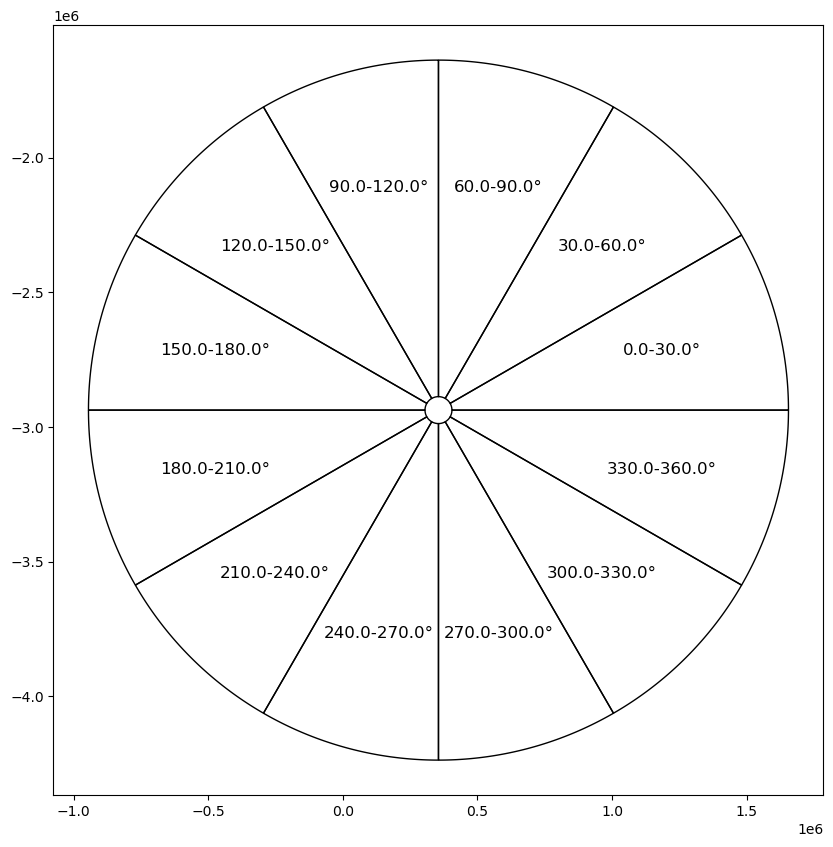

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
wedge_buffers.plot(ax=ax, color='none', edgecolor='black')

# Add labels to each wedge
for idx, row in wedge_buffers.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['angle_range'], fontsize=12, ha='center', va='center')

plt.show()

# combine values

In [61]:
geo_units_areas_by_wedge = [g.area.sum() for g in intersecting_units_list]

# Convert the list into a DataFrame
df = pd.DataFrame(mineral_area_within_wedge)

# Pivot the DataFrame
pivot_df = df.pivot_table(index='angle_range', columns='mineral_category', values='area_within_wedge', aggfunc='sum')

# Reset index to get 'angle_range' as a column (optional)
pivot_df.reset_index(inplace=True)

# Step 1: Extract mineral names (before parentheses)
pivot_df.columns = pivot_df.columns.str.extract(r'([a-zA-Z0-9\s\+]+)')[0]

# Step 2: Group by mineral name and sum the values for each mineral
pivot_df_combined = pivot_df.groupby(pivot_df.columns, axis=1).sum()

# Step 3: Move the 'angle_range' column to the first position
pivot_df_combined = pivot_df_combined[['angle'] + [col for col in pivot_df_combined.columns if col != 'angle']]

# Sort the DataFrame by 'angle_range'
pivot_df_combined['angle_start'] = pivot_df_combined['angle'].str.split('-').str[0].astype(float)
pivot_df_combined = pivot_df_combined.sort_values(by='angle_start').drop(columns='angle_start').reset_index(drop=True)

# Display the result
pivot_df_combined


,angle,Type 1 olivine,Type 2 olivine,hcp + olivine,lcp,plagioclase
0,0.0-30.0°,1.469374e+08,1.607845e+08,4.167926e+08,2.636916e+08,1.130312e+07
1,30.0-60.0°,2.140505e+08,5.388808e+08,2.607322e+09,9.851615e+08,2.184374e+08
2,60.0-90.0°,1.932604e+08,2.601625e+08,6.563191e+08,2.780963e+08,1.366037e+08
3,90.0-120.0°,2.810721e+08,5.263654e+08,9.325489e+08,1.182302e+08,1.892151e+07
4,120.0-150.0°,4.075916e+07,4.282374e+07,3.576322e+07,1.321453e+08,2.110267e+07
5,150.0-180.0°,1.318814e+08,1.365960e+08,8.848181e+08,9.616747e+06,1.260531e+07
6,180.0-210.0°,5.478571e+07,2.624356e+08,5.250662e+07,6.304426e+06,9.705343e+06
7,210.0-240.0°,6.464924e+07,2.444557e+08,1.120475e+08,2.738165e+07,5.109062e+07
8,240.0-270.0°,4.786550e+07,5.763771e+07,4.584437e+07,0.000000e+00,0.000000e+00
9,270.0-300.0°,3.165829e+06,0.000000e+00,1.259170e+07,0.000000e+00,0.000000e+00


# make plots

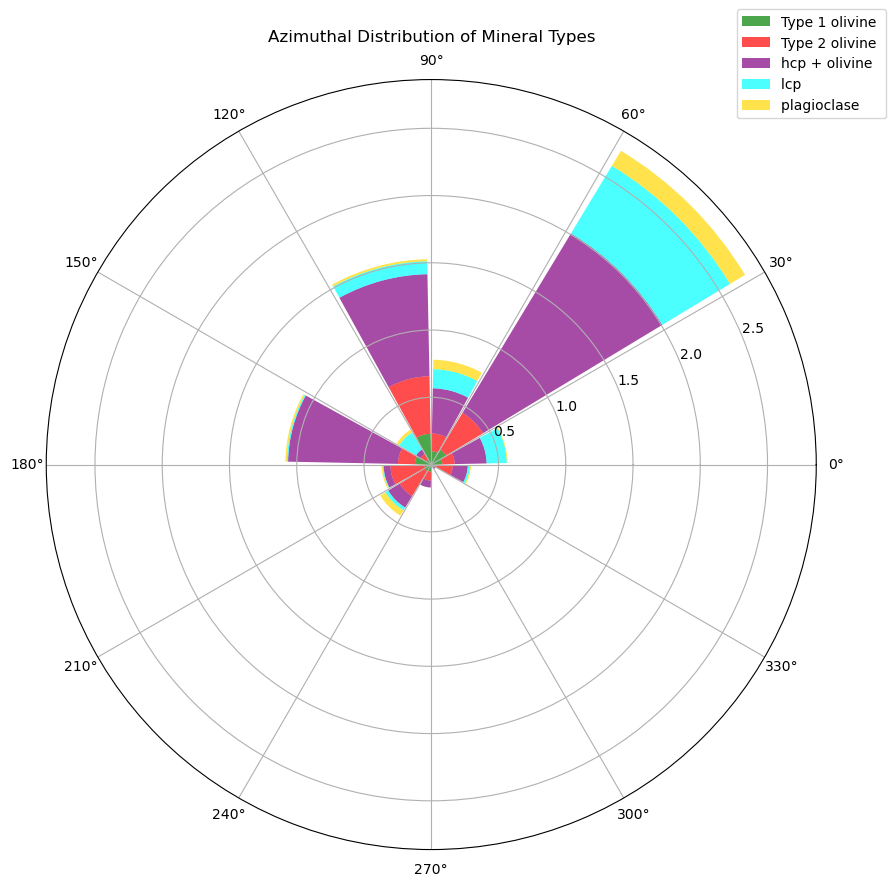

In [62]:
mineral_colors = [
    'green',  # Type 1 olivine
    'red',   # Type 2 olivine
    'purple',    # hcp + olivine
    'cyan',      # lcp
    'gold'    # plagioclase
]

# Prepare the data for plotting

# ----------------------------------------------------------------
# pick 1 of these:
# ----------------------------------------------------------------
# # case 0: 
# # no normalization
# pivot_df_combined_normalized = pivot_df_combined.drop('angle', axis=1).copy()

# ----------------------------------------------------------------

# case 1:
# # Normalize the values to 100%
# pivot_df_combined_normalized = pivot_df_combined.drop('angle', axis=1).div(pivot_df_combined.drop('angle', axis=1).sum(axis=1), axis=0) * 100
# ----------------------------------------------------------------

# # case 2:
# # normalize to wedge with max area
# # Calculate the maximum area across all rows (row with highest total area)
# max_area = pivot_df_combined.drop('angle', axis=1).sum(axis=1).max()

# # Normalize each row by the maximum area value
# pivot_df_combined_normalized = pivot_df_combined.drop('angle', axis=1).div(max_area) * 100
# ----------------------------------------------------------------

# # case 3:
# normalize each column by the geounit area within that wedge.
geo_units_areas_by_wedge_series = pd.Series(geo_units_areas_by_wedge)

# Divide each row by the corresponding value in geo_units_areas_by_wedge and multiply by 100 for percentage
pivot_df_combined_normalized = pivot_df_combined.drop('angle', axis=1).div(geo_units_areas_by_wedge_series, axis=0) * 100

# ----------------------------------------------------------------

# convert NaN to 0
pivot_df_combined_normalized = pivot_df_combined_normalized.fillna(0)

categories = pivot_df_combined_normalized.columns

# Flip theta to get the right order
theta = np.linspace(0, 2 * np.pi, len(angles)-1, endpoint=False)  # Angles in radians
width = 2 * np.pi / len(angles)  # Width of each bar

# Plotting
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Prepare the stacked bar plot
bottom = np.zeros(len(pivot_df_combined_normalized))

for i, (category, color) in enumerate(zip(categories, mineral_colors)):
    heights = pivot_df_combined_normalized[category]
    ax.bar(
        theta + 0.5 * np.deg2rad(360/num_wedges), 
        heights,
        width=width,
        bottom=bottom,
        label=category,
        color=color,
        alpha=0.7
    )
    # Update the bottom for the next category's stacking
    bottom += heights

# Customize the plot
ax.set_theta_direction(1)  # Counterclockwise direction
ax.set_xticks(theta)  # Set the locations of the x-ticks
# ax.set_yscale('log')  # Set y-axis to log scale
ax.set_title('Azimuthal Distribution of Mineral Types', va='bottom')
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

In [78]:
proportions = 100 * (pivot_df_combined.iloc[:,1:].sum() / pivot_df_combined.iloc[:,1:].sum().sum())
proportions

0
Type 1 olivine     10.469530
Type 2 olivine     20.520161
hcp + olivine      49.580798
lcp                15.330468
plagioclase         4.099044
dtype: float64

| GeoUnit Name                          |
|---------------------------------------|
| Argyre basin member 2                 |
| Argyre basin member 3                 |
| Argyre rim materials                  |
| Argyre rim and basin materials        |
| Argyre rim and basin materials |
| Argyre basin and rim materials        |
| Young crater materials                |
| Old crater materials                  |


| CRISM MRDR ID | Plagioclase (y/n) |
|--------------|------------------|
| T0182       |        n          |
| T0183       |                  |
| T0184       |                  |
| T0185       |                  |
| T0186       |       n           |
| T0235       |                  |
| T0236       |                  |
| T0237       |                  |
| T0238       |                  |
| T0239       |                  |
| T0240       |                  |
| T0289       |                  |
| T0290       |                  |
| T0293       |                  |
| T0294       |                  |
| T0359       |                  |
| T0360       |                  |
| T0361       |                  |
| T0362       |                  |
| T0363       |                  |
| T0364       |                  |
| T0365       |                  |
| T0431       |                  |
| T0432       |                  |
| T0433       |                  |
| T0434       |                  |
| T0435       |                  |
| T0436       |                  |
| T0437       |                  |
| T0503       |                  |
| T0504       |                  |
| T0505       |                  |
| T0506       |                  |
| T0507       |                  |
| T0508       |                  |
| T0576       |                  |
| T0577       |                  |
| T0578       |                  |
| T0579       |                  |
| T0580       |                  |
